In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


# Any results you write to the current directory are saved as output.

## Import Sessions file and Train files

In [58]:
#import sessions file
sessions = pd.read_csv("sessions.csv")
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [59]:
sessions.action.value_counts()

show                         2768278
index                         843699
search_results                725226
personalize                   706824
search                        536057
ajax_refresh_subtotal         487744
update                        365130
similar_listings              364624
social_connections            339000
reviews                       320591
active                        188036
similar_listings_v2           168788
lookup                        162041
create                        155887
dashboard                     152952
header_userpic                141830
collections                   124417
edit                          109083
campaigns                     105028
track_page_view                81117
unavailabilities               78317
qt2                            64651
notifications                  59392
confirm_email                  58726
requested                      57034
identity                       53631
ajax_check_dates               52517
s

In [60]:
# Removing Session Data with Null User Ids
sessions.isna().sum()
print(len(sessions))
sessions = sessions.dropna(axis=0, subset=['user_id'])
print(len(sessions))
sessions.info()

10567737
10533241
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10533241 entries, 0 to 10567736
Data columns (total 6 columns):
user_id          object
action           object
action_type      object
action_detail    object
device_type      object
secs_elapsed     float64
dtypes: float64(1), object(5)
memory usage: 562.5+ MB


In [61]:
sessions.action_type.value_counts()

view                3549375
data                2096655
click               1990058
-unknown-           1028251
submit               620063
message_post          86925
partner_callback      19053
booking_request       18762
modify                 1138
booking_response          4
Name: action_type, dtype: int64

In [62]:
sessions.action_detail.value_counts()

view_search_results               1771026
p3                                1371626
-unknown-                         1028222
wishlist_content_update            704782
user_profile                       654626
change_trip_characteristics        486414
similar_listings                   363423
user_social_connections            335577
listing_reviews                    267991
update_listing                     267776
dashboard                          152515
user_wishlists                     152260
header_userpic                     141315
message_thread                     132199
edit_profile                       108531
message_post                        86925
contact_host                        80872
unavailable_dates                   77475
confirm_email_link                  58253
create_user                         54611
change_contact_host_dates           52426
user_profile_content_update         50353
user_reviews                        49424
p5                                

In [63]:
# rename the ID to User_Id for merging with sessions data
train = pd.read_csv('train_users_2.csv')
train.rename(columns={'id' : 'user_id'},inplace=True)
print(len(train))

train.head()

# developed the booking = 0/1 based on booking date
train['stringdate'] = train.date_first_booking.astype(str)
train.loc[train['stringdate'] == 'nan', 'booked'] = 0
train.loc[train['stringdate'] != 'nan', 'booked'] = 1

print(train.booked.value_counts())
train.head()

213451
0.0    124543
1.0     88908
Name: booked, dtype: int64


,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,stringdate,booked
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,nan,0.0
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,nan,0.0
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2010-08-02,1.0
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2012-09-08,1.0
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2010-02-18,1.0


In [64]:
train['age_b'] = 1
train.loc[train['age'] <26, 'age_b'] = 0
train.loc[train['age'] >42, 'age_b'] = 0
train.loc[train['age'].isnull(), 'age_b'] = 0

train.age_b.value_counts()

0    135650
1     77801
Name: age_b, dtype: int64

In [65]:
train['first_active'] = train.timestamp_first_active.astype(str)
print(len(train))
train.head()

train['first_active'] = train.first_active.apply(lambda x: datetime.strptime(x, '%Y%m%d%H%M%S'))

train['time_active'] = (pd.to_datetime(train.date_account_created)- train.first_active).dt.days

train['PC_Device'] = 0
train.loc[train['first_device_type'] == 'Windows Desktop', 'PC_Device'] = 1
train.loc[train['first_device_type'] == 'Mac Desktop', 'PC_Device'] = 1
train.loc[train['first_device_type'] == 'Desktop (Other)', 'PC_Device'] = 1

train['Mac_PC'] = 0
train.loc[train['first_device_type'] == 'Mac Desktop', 'Mac_PC'] = 1

print(train.PC_Device.value_counts())
train.head()


213451
1    163515
0     49936
Name: PC_Device, dtype: int64


,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,first_device_type,first_browser,country_destination,stringdate,booked,age_b,first_active,time_active,PC_Device,Mac_PC
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,...,Mac Desktop,Chrome,NDF,nan,0.0,0,2009-03-19 04:32:55,465,1,1
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,...,Mac Desktop,Chrome,NDF,nan,0.0,1,2009-05-23 17:48:09,731,1,1
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,...,Windows Desktop,IE,US,2010-08-02,1.0,0,2009-06-09 23:12:47,475,1,0
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,...,Mac Desktop,Firefox,other,2012-09-08,1.0,1,2009-10-31 06:01:29,764,1,1
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,...,Mac Desktop,Chrome,US,2010-02-18,1.0,1,2009-12-08 06:11:05,279,1,1


In [66]:
train.time_active.describe()

count    213451.000000
mean         -0.768181
std          11.948395
min          -1.000000
25%          -1.000000
50%          -1.000000
75%          -1.000000
max        1455.000000
Name: time_active, dtype: float64

### Want a file that is User_Id and the booking for correlation analyses

In [97]:
#want only the user_ids to merge with each session column of values
user_ids = train[['user_id','booked','age_b','PC_Device','Mac_PC']]

### Taking Fields and their Values and transposing them to do a Correlation Analyses to determine the top variables

### Starting with action field

In [98]:
#created a second field to count the actions
sessions['action_2'] = sessions.action

In [99]:
# created a datafile with only the actions and user_ids
user_actions = sessions.groupby(['user_id','action']).count()
user_actions.head(10)
df_actions = user_actions[['action_type']]
df_actions.head()
df_actions.reset_index(inplace=True)
df_actions.head(10)

,user_id,action,action_type
0,00023iyk9l,ajax_refresh_subtotal,2
1,00023iyk9l,callback,1
2,00023iyk9l,confirm_email,1
3,00023iyk9l,dashboard,4
4,00023iyk9l,header_userpic,2
5,00023iyk9l,index,4
6,00023iyk9l,pending,1
7,00023iyk9l,personalize,4
8,00023iyk9l,requested,5
9,00023iyk9l,search_results,1


In [100]:
print(len(user_actions))

1732721


In [101]:
# transposed all the actions into columns per unique ID
df = df_actions.pivot(index = 'user_id',columns='action', values='action_type')
df.tail(10)
df.fillna(0, inplace = True) 
df.head()

action,10,11,12,15,about_us,accept_decline,account,acculynk_bin_check_failed,acculynk_bin_check_success,acculynk_load_pin_pad,...,view,views,views_campaign,views_campaign_rules,webcam_upload,weibo_signup_referral_finish,why_host,widget,wishlists,zendesk_login_jwt
user_id,,,,,,,,,,,,,,,,,,,,,
00023iyk9l,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0010k6l0om,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001wyh0pz8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0028jgx1x1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002qnbzfs5,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
print(len(df))

135043


In [103]:
# merge the action columns with the train dataset
print(len(df))
mergeit = pd.merge(user_ids,df, on='user_id', how='right')
mergeit['session_flag'] = 1
print(len(mergeit))
mergeit.head()

135043
135043


,user_id,booked,age_b,PC_Device,Mac_PC,10,11,12,15,about_us,...,views,views_campaign,views_campaign_rules,webcam_upload,weibo_signup_referral_finish,why_host,widget,wishlists,zendesk_login_jwt,session_flag
0,d1mm9tcy42,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,yo8nz8bqcq,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,4grx6yxeby,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,ncf87guaf0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,4rvqpxoh3h,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [104]:
#needed to create a file to grab all the coorelations to narrow them down
corr = mergeit.corr()
corr.head()

,booked,age_b,PC_Device,Mac_PC,10,11,12,15,about_us,accept_decline,...,views,views_campaign,views_campaign_rules,webcam_upload,weibo_signup_referral_finish,why_host,widget,wishlists,zendesk_login_jwt,session_flag
booked,1.000000,0.249283,0.144100,0.107005,0.024763,0.015586,0.057839,0.024967,0.003882,NaN,...,-0.005828,0.001180,-0.004172,0.039850,-0.003212,-0.007453,NaN,0.004618,-0.001962,NaN
age_b,0.249283,1.000000,0.038673,0.050472,0.017952,0.006293,0.019307,0.013342,-0.000688,NaN,...,-0.002389,0.001805,-0.003718,0.030805,0.001107,-0.005399,NaN,0.005181,0.003684,NaN
PC_Device,0.144100,0.038673,1.000000,0.507478,-0.054858,-0.022133,0.017105,-0.036181,0.009685,NaN,...,0.004720,0.003378,0.003378,0.034398,0.005342,0.012018,NaN,0.002389,-0.002448,NaN
Mac_PC,0.107005,0.050472,0.507478,1.000000,-0.027768,-0.011619,0.016337,-0.022508,-0.002093,NaN,...,0.001109,-0.004093,0.001282,0.032465,0.007127,-0.000132,NaN,-0.002894,0.000423,NaN
10,0.024763,0.017952,-0.054858,-0.027768,1.000000,0.026032,0.053766,-0.001450,-0.000370,-0.000146,...,-0.000462,-0.000206,-0.000206,0.000497,-0.000936,-0.001583,NaN,-0.000146,0.001660,NaN


In [105]:
#Sending the correlation to excel in order to identify the top 15 actions
corr.to_csv('correlation_action.csv')

In [106]:
#mergeit.reset_index(inplace=True)
mergeit.head()

,user_id,booked,age_b,PC_Device,Mac_PC,10,11,12,15,about_us,...,views,views_campaign,views_campaign_rules,webcam_upload,weibo_signup_referral_finish,why_host,widget,wishlists,zendesk_login_jwt,session_flag
0,d1mm9tcy42,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,yo8nz8bqcq,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,4grx6yxeby,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,ncf87guaf0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,4rvqpxoh3h,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [107]:
list(mergeit.columns)

['user_id',
 'booked',
 'age_b',
 'PC_Device',
 'Mac_PC',
 '10',
 '11',
 '12',
 '15',
 'about_us',
 'accept_decline',
 'account',
 'acculynk_bin_check_failed',
 'acculynk_bin_check_success',
 'acculynk_load_pin_pad',
 'acculynk_pin_pad_error',
 'acculynk_pin_pad_inactive',
 'acculynk_pin_pad_success',
 'acculynk_session_obtained',
 'active',
 'add_business_address_colorbox',
 'add_guest_colorbox',
 'add_guests',
 'add_note',
 'agree_terms_check',
 'agree_terms_uncheck',
 'airbnb_picks',
 'airbrb',
 'ajax_check_dates',
 'ajax_get_referrals_amt',
 'ajax_get_results',
 'ajax_google_translate',
 'ajax_google_translate_description',
 'ajax_google_translate_reviews',
 'ajax_image_upload',
 'ajax_ldp',
 'ajax_lwlb_contact',
 'ajax_payout_edit',
 'ajax_payout_options_by_country',
 'ajax_payout_split_edit',
 'ajax_photo_widget',
 'ajax_photo_widget_form_iframe',
 'ajax_price_and_availability',
 'ajax_referral_banner_experiment_type',
 'ajax_referral_banner_type',
 'ajax_refresh_subtotal',
 'aja

## Makes the pandas df for action 

In [108]:
secs = sessions.groupby('user_id').sum()
secs['mins_elapsed'] = secs.secs_elapsed/60
secs.head()

# merge the action details columsn with the train dataset
print(len(secs))
mergeit_secs = pd.merge(user_ids,secs, on='user_id', how='outer')
print(len(mergeit_secs))
mergeit_secs.head()

135483
275119


,user_id,booked,age_b,PC_Device,Mac_PC,secs_elapsed,mins_elapsed
0,gxn3p5htnn,0.0,0.0,1.0,1.0,NaN,NaN
1,820tgsjxq7,0.0,1.0,1.0,1.0,NaN,NaN
2,4ft3gnwmtx,1.0,0.0,1.0,0.0,NaN,NaN
3,bjjt8pjhuk,1.0,1.0,1.0,1.0,NaN,NaN
4,87mebub9p4,1.0,1.0,1.0,1.0,NaN,NaN


In [112]:
secelapsed_col = mergeit_secs[['user_id','secs_elapsed']]
secelapsed_col.head()

,user_id,secs_elapsed
0,gxn3p5htnn,NaN
1,820tgsjxq7,NaN
2,4ft3gnwmtx,NaN
3,bjjt8pjhuk,NaN
4,87mebub9p4,NaN


In [113]:
actions = pd.merge(secelapsed_col, mergeit, on='user_id',how='right')
print(len(actions))

135043


In [114]:
actions.head()

,user_id,secs_elapsed,booked,age_b,PC_Device,Mac_PC,10,11,12,15,...,views,views_campaign,views_campaign_rules,webcam_upload,weibo_signup_referral_finish,why_host,widget,wishlists,zendesk_login_jwt,session_flag
0,d1mm9tcy42,3427529.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,yo8nz8bqcq,207842.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,4grx6yxeby,1135444.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,ncf87guaf0,3755100.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,4rvqpxoh3h,2555.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [115]:
action_col = actions[['user_id','booked', 'requested', 'verify', 'confirm_email', 'travel_plans_current', 'pending',
                      'at_checkpoint','age_b', 'PC_Device', 'dashboard','identity','cancellation_policies','edit',
                      'ajax_image_upload','agree_terms_check','kba', 'message_to_host_change','phone_number_widget','show_personalize',
                      'request_new_confirm_email', 'set_user', 'secs_elapsed','session_flag','Mac_PC']]
action_col.head()

,user_id,booked,requested,verify,confirm_email,travel_plans_current,pending,at_checkpoint,age_b,PC_Device,...,agree_terms_check,kba,message_to_host_change,phone_number_widget,show_personalize,request_new_confirm_email,set_user,secs_elapsed,session_flag,Mac_PC
0,d1mm9tcy42,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3427529.0,1,0.0
1,yo8nz8bqcq,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,207842.0,1,1.0
2,4grx6yxeby,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1135444.0,1,0.0
3,ncf87guaf0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3755100.0,1,0.0
4,4rvqpxoh3h,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2555.0,1,0.0


In [116]:
action_col.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135043 entries, 0 to 135042
Data columns (total 25 columns):
user_id                      135043 non-null object
booked                       73406 non-null float64
requested                    135043 non-null float64
verify                       135043 non-null float64
confirm_email                135043 non-null float64
travel_plans_current         135043 non-null float64
pending                      135043 non-null float64
at_checkpoint                135043 non-null float64
age_b                        73406 non-null float64
PC_Device                    73406 non-null float64
dashboard                    135043 non-null float64
identity                     135043 non-null float64
cancellation_policies        135043 non-null float64
edit                         135043 non-null float64
ajax_image_upload            135043 non-null float64
agree_terms_check            135043 non-null float64
kba                          135043 non-null 

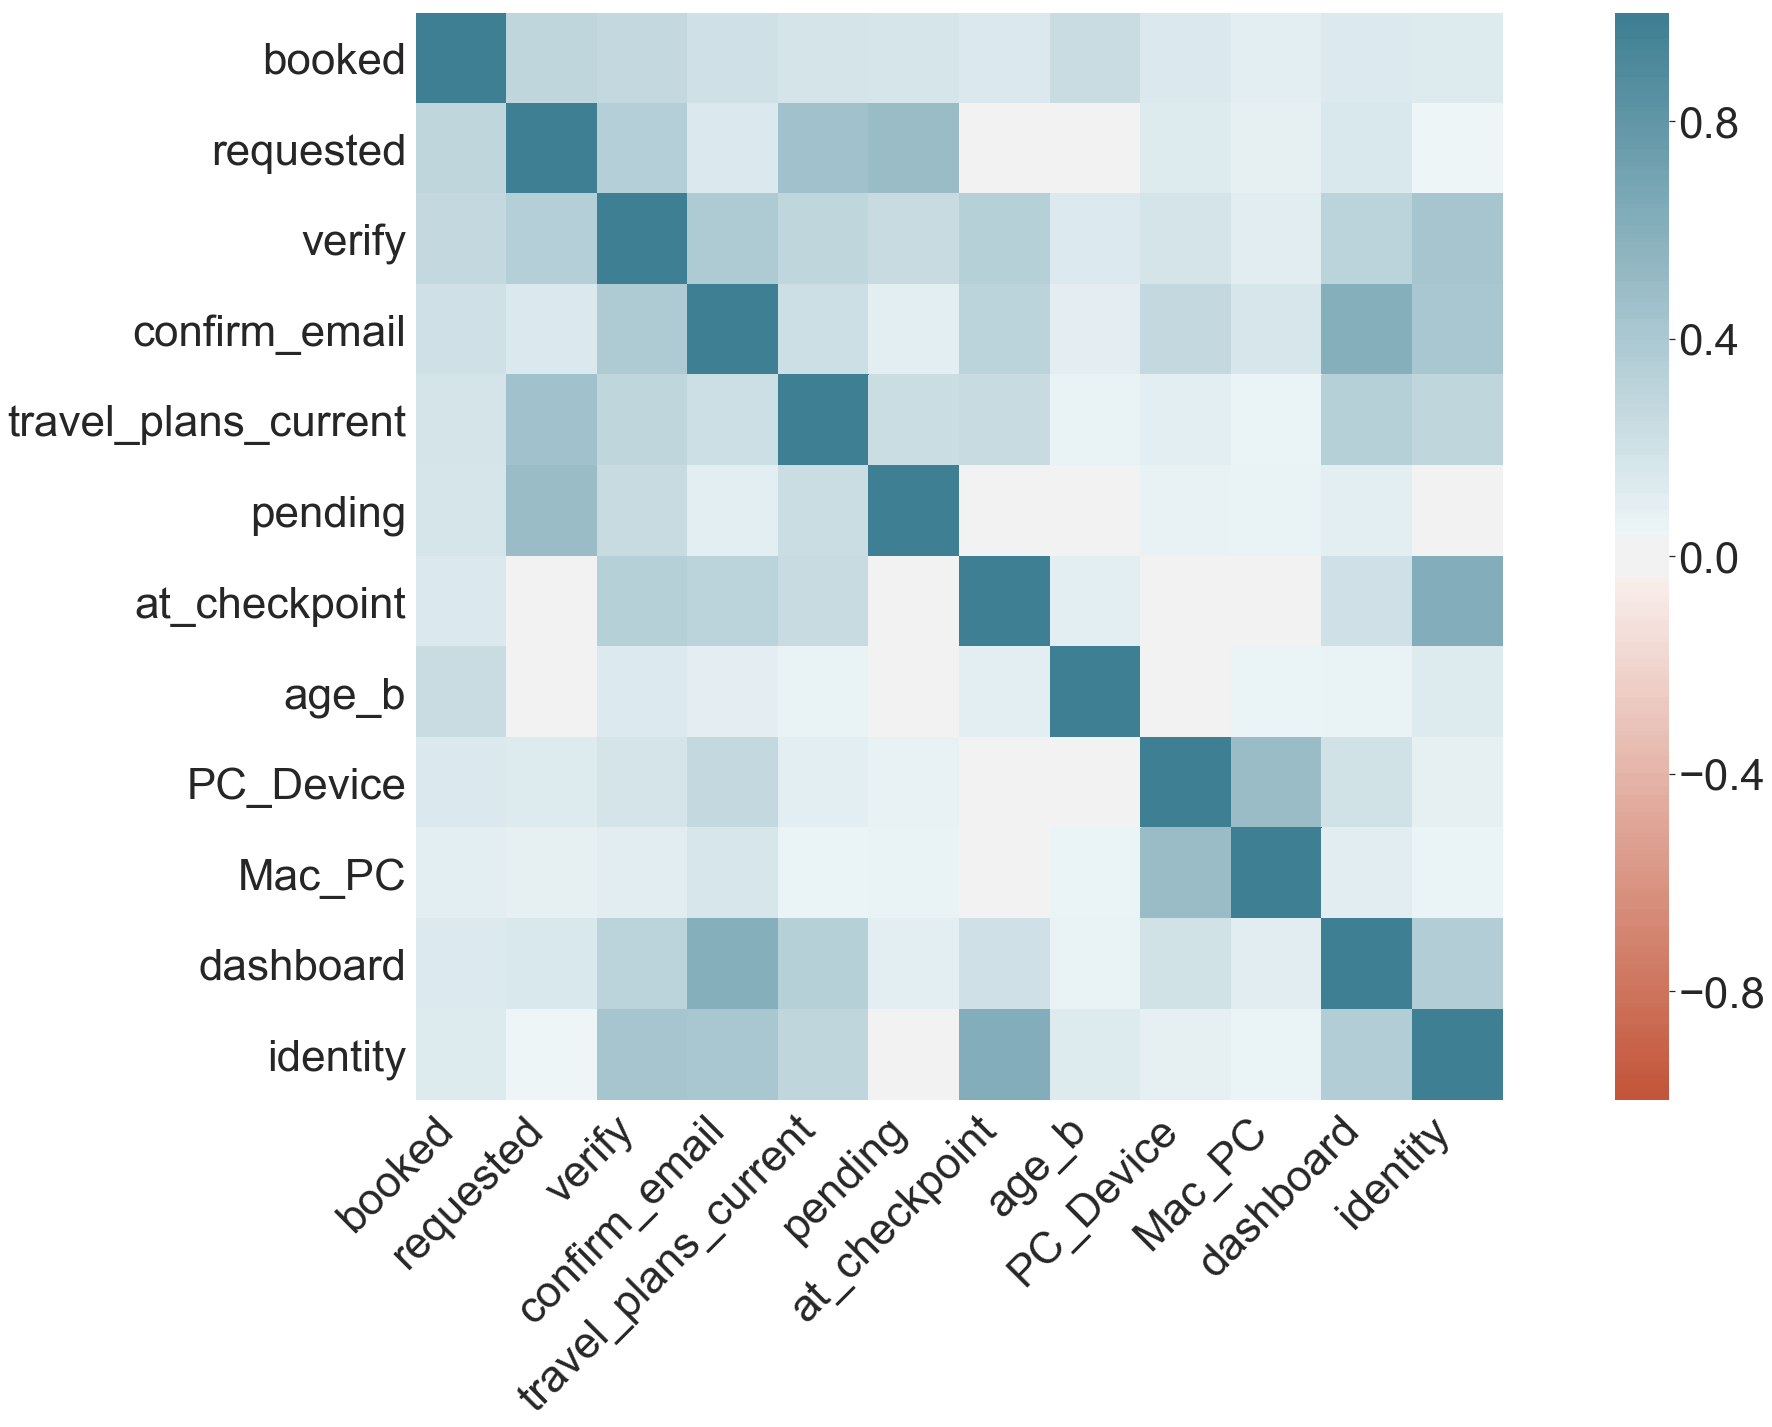

In [118]:
data1 = action_col[['booked', 'requested', 'verify', 'confirm_email', 'travel_plans_current', 'pending',
                      'at_checkpoint','age_b', 'PC_Device','Mac_PC','dashboard','identity']]

data2 = action_col[['booked','edit',
                      'ajax_image_upload','agree_terms_check','kba', 'message_to_host_change','phone_number_widget','show_personalize',
                      'request_new_confirm_email', 'set_user','identity','at_checkpoint','Mac_PC']]


fig = plt.figure(figsize=(40,20)),
corr = data1.corr()
sns.set(font_scale = 4)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

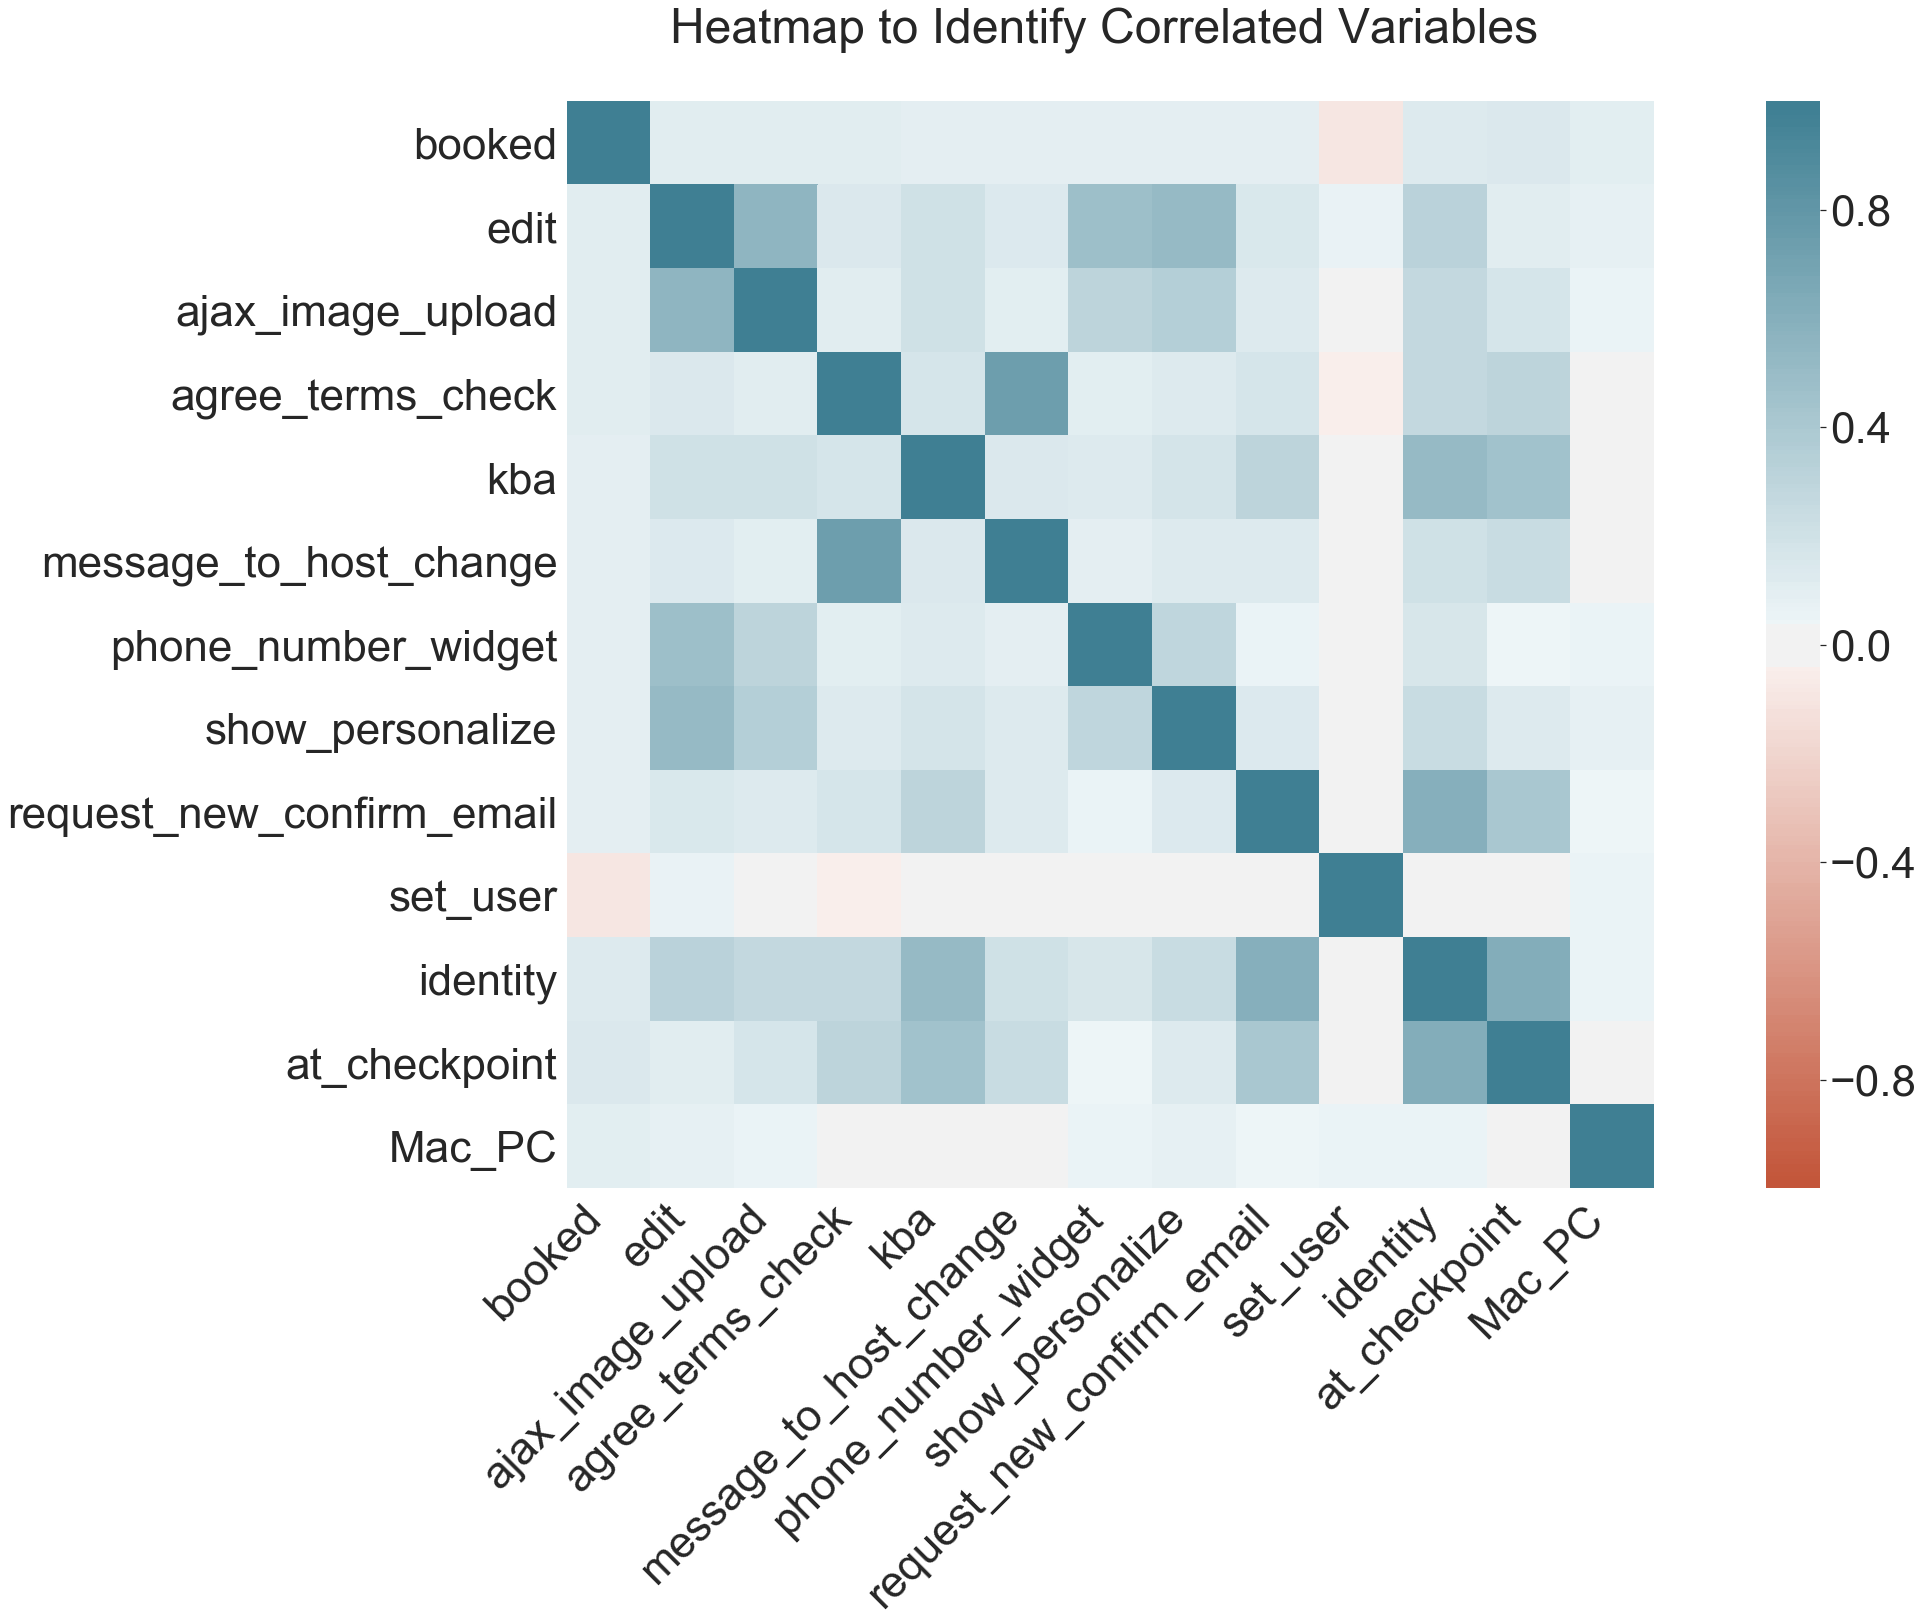

In [119]:

fig = plt.figure(figsize=(40,20))
corr = data2.corr()
sns.set(font_scale = 4)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.title("Heatmap to Identify Correlated Variables \n")
plt.savefig('heatmap_corrs.png')

In [121]:
columns = ['user_id','booked','requested', 'verify', 'travel_plans_current',
                      'age_b', 'PC_Device', 'cancellation_policies',
                      'agree_terms_check','kba','show_personalize',
                      'request_new_confirm_email', 'set_user', 'secs_elapsed','Mac_PC'] 
corr = action_col[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') 

corr.to_csv('correlations.csv')

In [122]:
# 'user_id','booked','requested', 'verify', 'travel_plans_current',
# 'age_b', 'PC_Device', 'cancellation_policies',
# 'agree_terms_check','kba','show_personalize',
# 'request_new_confirm_email', 'set_user', 'secs_elapsed'

<Figure size 2880x1440 with 0 Axes>

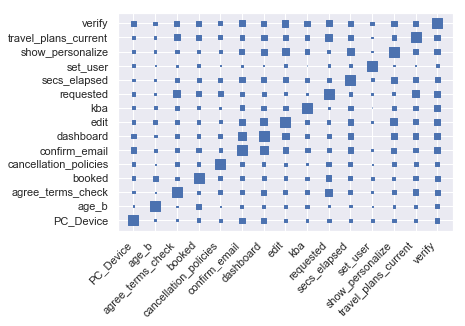

In [123]:

# Step 1 - Make a scatter plot with square markers, set column names as labels

def heatmap(x, y, size):
   
    fig, ax = plt.subplots()
    
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 100
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
  
    

columns = ['booked','requested', 'verify', 'confirm_email', 'travel_plans_current'
                     ,'age_b', 'PC_Device', 'dashboard','cancellation_policies','edit',
                      'agree_terms_check','kba','show_personalize',
                       'set_user', 'secs_elapsed'] 
corr = action_col[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']

fig = plt.figure(figsize=(40,20))
sns.set(font_scale = 1)
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)



In [129]:
the_actions = action_col[['user_id','requested', 'verify', 'confirm_email', 'travel_plans_current', 'pending',
                       'dashboard','identity','cancellation_policies','edit',
                      'agree_terms_check','show_personalize',
                      'set_user', 'secs_elapsed', 'session_flag']]

len(user_ids)
df = pd.merge(user_ids,the_actions, on='user_id',how='left')
print(len(df))
df.head()


213451


,user_id,booked,age_b,PC_Device,Mac_PC,requested,verify,confirm_email,travel_plans_current,pending,dashboard,identity,cancellation_policies,edit,agree_terms_check,show_personalize,set_user,secs_elapsed,session_flag
0,gxn3p5htnn,0.0,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,820tgsjxq7,0.0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,1.0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,1.0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87mebub9p4,1.0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clean the null values

In [130]:
# Create null column values; 0/1 as advised by Taran
cols = df.columns[5:]
cols

Index(['requested', 'verify', 'confirm_email', 'travel_plans_current',
       'pending', 'dashboard', 'identity', 'cancellation_policies', 'edit',
       'agree_terms_check', 'show_personalize', 'set_user', 'secs_elapsed',
       'session_flag'],
      dtype='object')

In [131]:



for col in cols:
    newcol = col + '_u'
    print(col)
    print(newcol)
    df.loc[df[col].isnull(), newcol] = 0
    df.loc[df[col].notnull(),newcol] = 1

    
df.head()
df.verify_u.value_counts()

requested
requested_u
verify
verify_u
confirm_email
confirm_email_u
travel_plans_current
travel_plans_current_u
pending
pending_u
dashboard
dashboard_u
identity
identity_u
cancellation_policies
cancellation_policies_u
edit
edit_u
agree_terms_check
agree_terms_check_u
show_personalize
show_personalize_u
set_user
set_user_u
secs_elapsed
secs_elapsed_u
session_flag
session_flag_u


0.0    140045
1.0     73406
Name: verify_u, dtype: int64

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 33 columns):
user_id                    213451 non-null object
booked                     213451 non-null float64
age_b                      213451 non-null int64
PC_Device                  213451 non-null int64
Mac_PC                     213451 non-null int64
requested                  73406 non-null float64
verify                     73406 non-null float64
confirm_email              73406 non-null float64
travel_plans_current       73406 non-null float64
pending                    73406 non-null float64
dashboard                  73406 non-null float64
identity                   73406 non-null float64
cancellation_policies      73406 non-null float64
edit                       73406 non-null float64
agree_terms_check          73406 non-null float64
show_personalize           73406 non-null float64
set_user                   73406 non-null float64
secs_elapsed               73406 non-null

In [133]:
# create a new column for 0/1 for 1 if you did the event, otherwise 0
for col in cols:
    newcol = col + '_1'
    print(col)
    print(newcol)
    df.loc[df[col] == 1, newcol] = 1
    df.loc[df[col] != 1 ,newcol] = 0

    
df.head()
df.verify_1.value_counts()

requested
requested_1
verify
verify_1
confirm_email
confirm_email_1
travel_plans_current
travel_plans_current_1
pending
pending_1
dashboard
dashboard_1
identity
identity_1
cancellation_policies
cancellation_policies_1
edit
edit_1
agree_terms_check
agree_terms_check_1
show_personalize
show_personalize_1
set_user
set_user_1
secs_elapsed
secs_elapsed_1
session_flag
session_flag_1


0.0    200936
1.0     12515
Name: verify_1, dtype: int64

In [134]:
#delete the original field
for col in cols:
    df.drop(col, axis = 1, inplace = True) 
  
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 33 columns):
user_id                    213451 non-null object
booked                     213451 non-null float64
age_b                      213451 non-null int64
PC_Device                  213451 non-null int64
Mac_PC                     213451 non-null int64
requested_u                213451 non-null float64
verify_u                   213451 non-null float64
confirm_email_u            213451 non-null float64
travel_plans_current_u     213451 non-null float64
pending_u                  213451 non-null float64
dashboard_u                213451 non-null float64
identity_u                 213451 non-null float64
cancellation_policies_u    213451 non-null float64
edit_u                     213451 non-null float64
agree_terms_check_u        213451 non-null float64
show_personalize_u         213451 non-null float64
set_user_u                 213451 non-null float64
secs_elapsed_u             21

In [135]:
# output the cleaned file for modeling
train_file3 = df.to_csv("train_file_427.csv", index=False)

In [136]:
df.booked.value_counts()

0.0    124543
1.0     88908
Name: booked, dtype: int64

## BUILD MODEL - RUN LOGISTIC REGRESSION


In [96]:
# this is done in Logistic_Regression python file that Juan created